# Personal Project no. 1 - telecom customer churn

## Notebook 1 - Data cleaning and EDA

In this project, I will create predictive models to estimate whether a customer for a telecom company will turn over or churn. The data comes from an old Kaggle competition: https://www.kaggle.com/blastchar/telco-customer-churn/data#

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import style

from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from plotly import graph_objects as go

from scipy.stats import chi2_contingency
from scipy.stats import chi2
from tqdm import tqdm
from dython.model_utils import roc_graph
from dython.nominal import associations

from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

### Data import and cleaning

From Kaggle:  

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

Customers who left within the last month – the column is called Churn
Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
Demographic info about customers – gender, age range, and if they have partners and dependents

In [57]:
#import data and show the head
df = pd.read_csv('datasets_13996_18858_WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [4]:
#look for null values
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
#examine the data for anomalies
for i in df.columns:
    print(df[i].value_counts())

3026-ATZYV    1
8050-XGRVL    1
6402-SSEJG    1
9837-FWLCH    1
1618-CFHME    1
             ..
1550-EENBN    1
3507-GASNP    1
2400-FEQME    1
4619-EVPHY    1
6447-GORXK    1
Name: customerID, Length: 7043, dtype: int64
Male      3555
Female    3488
Name: gender, dtype: int64
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
No     3641
Yes    3402
Name: Partner, dtype: int64
No     4933
Yes    2110
Name: Dependents, dtype: int64
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64
Yes    6361
No      682
Name: PhoneService, dtype: int64
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
No                     3088
Yes

In [6]:
print(len(df))
df = df[df['TotalCharges'] != ' ']
print(len(df))

7043
7032


In [7]:
df['SeniorCitizen'] = df['SeniorCitizen'].replace([1, 0], ['SeniorC', 'Not SeniorC'])
#df['Churn'] = df['Churn'].replace(["Yes", "No"], [1,0])
df['TotalCharges'] = df['TotalCharges'].astype('float')
df = df.drop(['customerID'], axis=1)

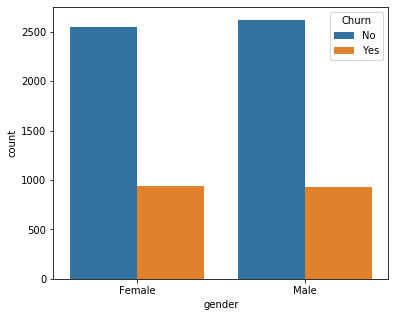

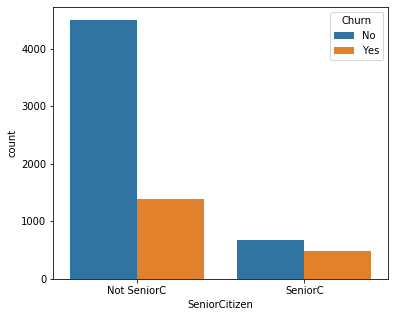

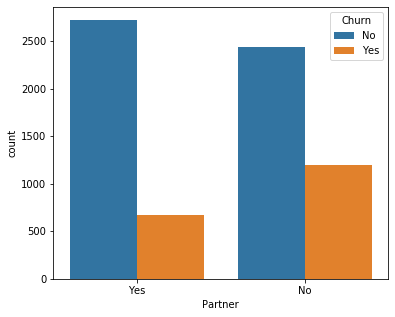

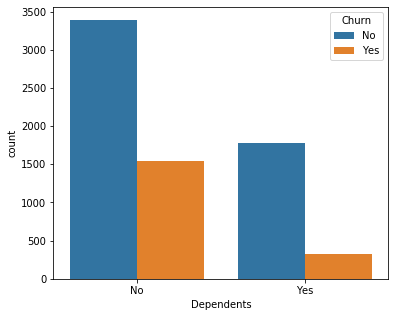

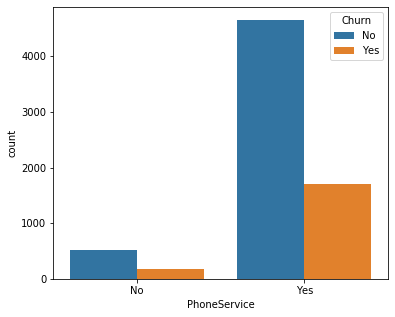

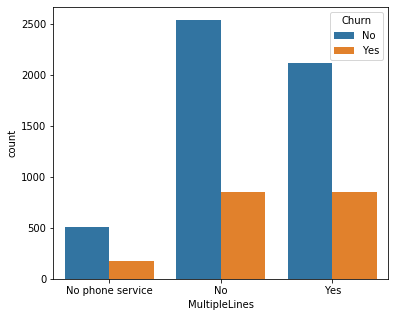

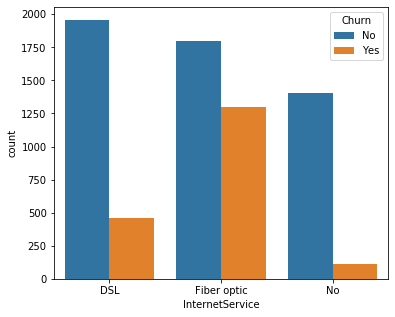

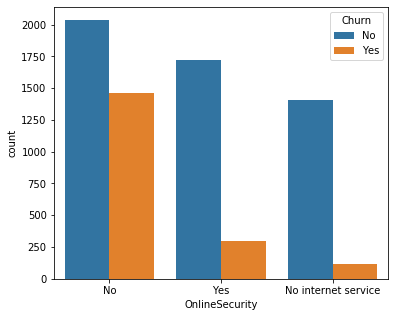

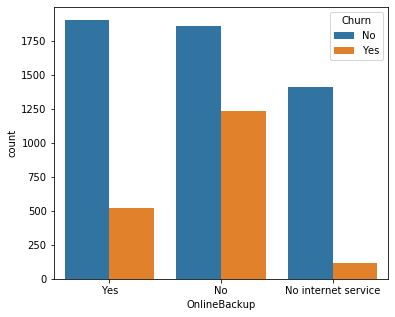

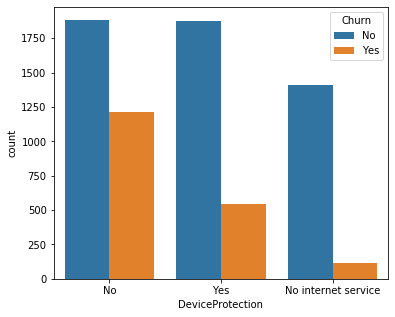

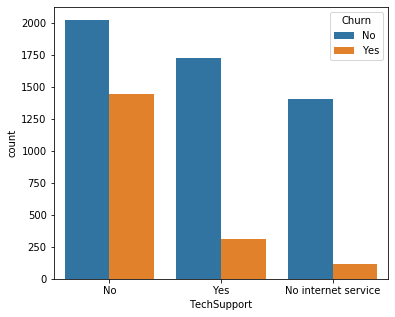

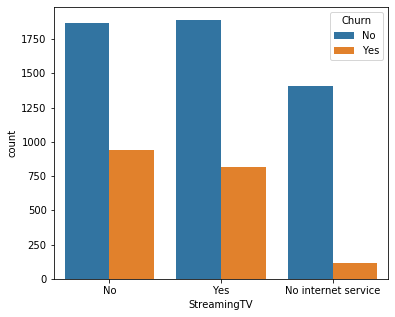

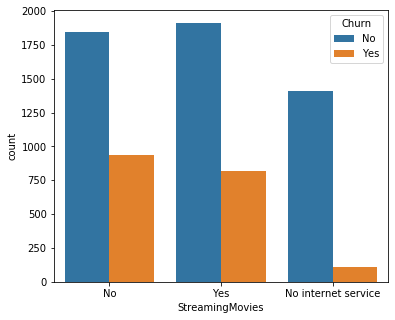

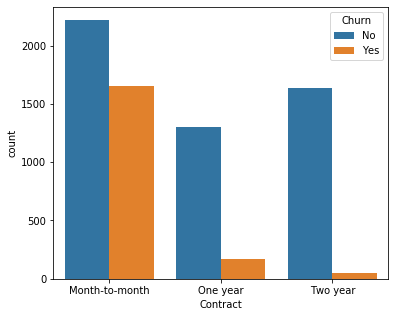

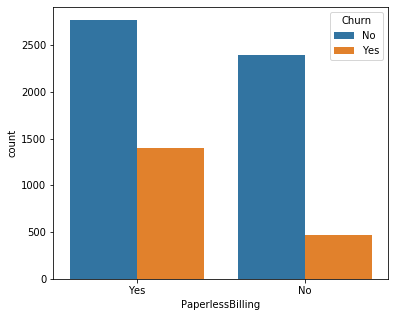

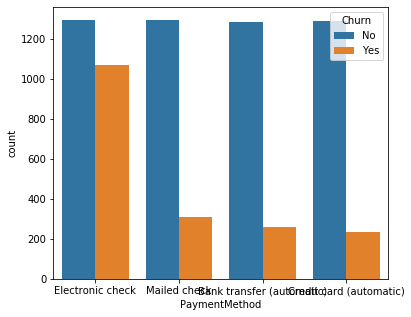

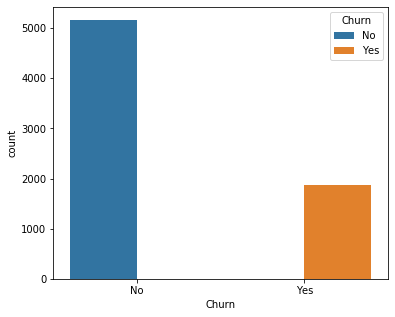

In [8]:
X = list(i for i in df._get_numeric_data().columns)
Y = list(i for i in df.columns if i not in X)

for i in Y:
    plt.figure(figsize=(6,5))
    sns.countplot(x=i, hue='Churn', data=df)

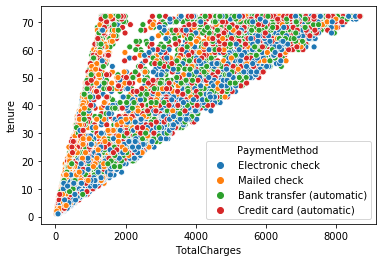

In [9]:
#Another way to visualize the data
sns.scatterplot(df.TotalCharges, df.tenure, df.PaymentMethod)

In [10]:
for i in df.columns:
    if df[i].dtype == 'float64':
        df[i] = df[i].astype('int64')
        
data_corr = df.copy()

In [11]:
data_corr.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

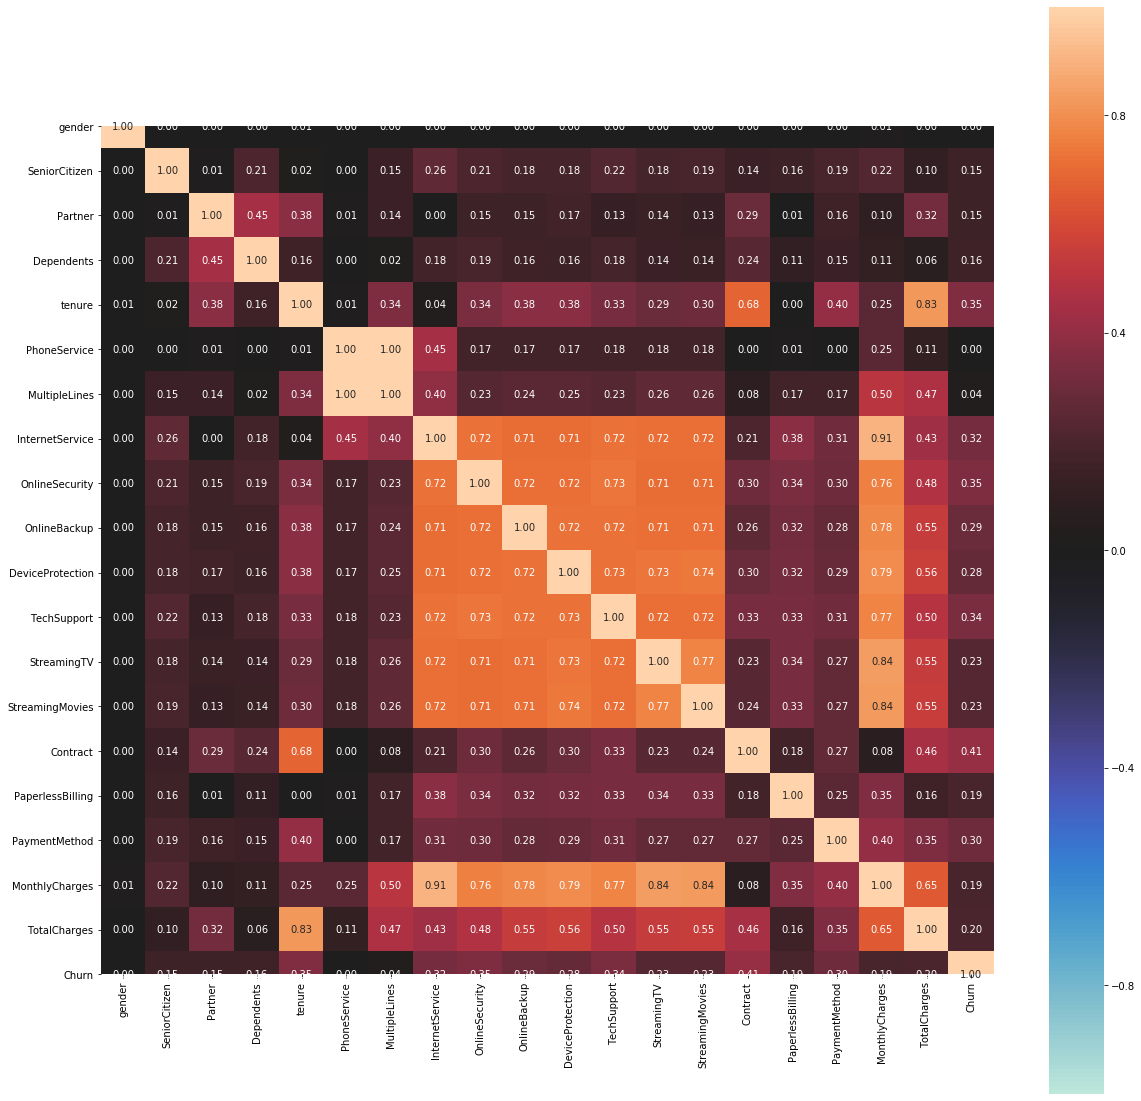

In [12]:
def associations_():
    associations(data_corr,nominal_columns=['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                                            'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                                            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                                            'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'])
    
plt.rcParams["figure.figsize"]=20,20
associations_()

In [13]:
data_corr = data_corr.drop(['tenure', 'MonthlyCharges', 'MultipleLines'], axis=1)

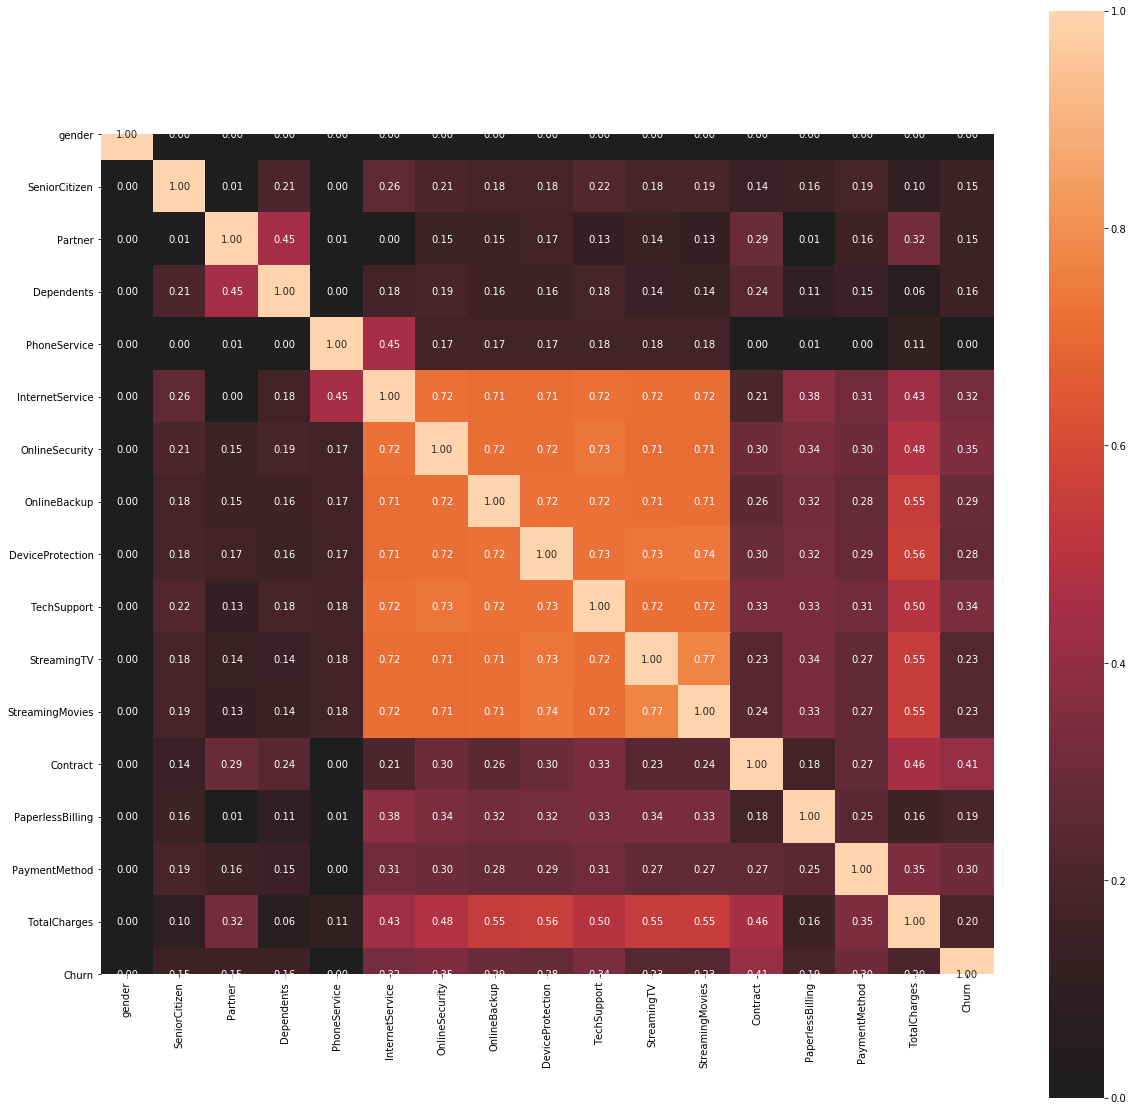

In [14]:
def associations_():
    associations(data_corr,nominal_columns=['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                                            'InternetService', 'OnlineSecurity', 'OnlineBackup',
                                            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                                            'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'])
    
plt.rcParams["figure.figsize"]=20,20
associations_()

In [15]:
data_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 17 columns):
gender              7032 non-null object
SeniorCitizen       7032 non-null object
Partner             7032 non-null object
Dependents          7032 non-null object
PhoneService        7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
TotalCharges        7032 non-null int64
Churn               7032 non-null object
dtypes: int64(1), object(16)
memory usage: 988.9+ KB


Here I use the chi-square test to drop a few features that might be independent of the target feature 'Churn'. I generate a crosstab/contigency table for each of the categorical variables and conduct a chi-square test for significance.

In [16]:
inspect = []
for i in data_corr.columns[:15]:
    obs = pd.crosstab(data_corr['Churn'], data_corr[i])
    stat, pval, df, expected = chi2_contingency(obs)
    if pval < 0.05:
        inspect.append(i)

inspect

['SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

The gender and PhoneService features were not significant, so they are removed from the categorical variables that might impact Churn.

In [17]:
data_corr = data_corr.drop(['gender', 'PhoneService'], axis=1)

I now need to transform the data into categorical features and standardize my numeric feature ('TotalCharges').

In [18]:
#preprocessing numerical
Num_features = data_corr.select_dtypes(include='int64').columns
data_corr[Num_features] = StandardScaler().fit_transform(data_corr[Num_features])
data_corr.head()

SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0   Not SeniorC     Yes         No             DSL             No   
1   Not SeniorC      No         No             DSL            Yes   
2   Not SeniorC      No         No             DSL            Yes   
3   Not SeniorC      No         No             DSL            Yes   
4   Not SeniorC      No         No     Fiber optic             No   

  OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
0          Yes               No          No          No              No   
1           No              Yes          No          No              No   
2          Yes               No          No          No              No   
3           No              Yes         Yes          No              No   
4           No               No          No          No              No   

         Contract PaperlessBilling              PaymentMethod  TotalCharges  \
0  Month-to-month              Yes           Electronic check     -0.994363   
1        One year               No               Mailed check     -0.173753   
2  Month-to-month              Yes               Mailed check     -0.959509   
3        One year               No  Bank transfer (automatic)     -0.195372   
4  Month-to-month              Yes           Electronic check     -0.940538   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [19]:
#Takes a while
costs = []
n_clusters = []
clusters_assigned = []

cat_cols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]

for i in tqdm(range(2, 10)):
    try:
        kproto = KPrototypes(n_clusters=i, init='Huang', verbose=2)
        clusters = kproto.fit_predict(data_corr, categorical=cat_cols)
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")

  0%|          | 0/8 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 884, ncost: 23586.852187324574
Run: 1, iteration: 2/100, moves: 356, ncost: 23316.834014475593
Run: 1, iteration: 3/100, moves: 80, ncost: 23296.32706217392
Run: 1, iteration: 4/100, moves: 13, ncost: 23296.325736972
Run: 1, iteration: 5/100, moves: 0, ncost: 23296.325736972
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 3211, ncost: 22416.542262683735
Run: 2, iteration: 2/100, moves: 725, ncost: 22026.578725687268
Run: 2, iteration: 3/100, moves: 160, ncost: 22017.683347720835
Run: 2, iteration: 4/100, moves: 23, ncost: 22017.394147666786
Run: 2, iteration: 5/100, moves: 2, ncost: 22017.391521031357
Run: 2, iteration: 6/100, moves: 0, ncost: 22017.391521031357
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 2104, ncost: 22140.60029687329
Run: 3,

 12%|█▎        | 1/8 [01:36<11:16, 96.66s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1603, ncost: 15949.57688389592
Run: 1, iteration: 2/100, moves: 135, ncost: 15945.487513383767
Run: 1, iteration: 3/100, moves: 8, ncost: 15945.441824368663
Run: 1, iteration: 4/100, moves: 0, ncost: 15945.441824368663
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 3121, ncost: 15988.605052596009
Run: 2, iteration: 2/100, moves: 353, ncost: 15953.957907043423
Run: 2, iteration: 3/100, moves: 38, ncost: 15953.076752529983
Run: 2, iteration: 4/100, moves: 15, ncost: 15952.946705462744
Run: 2, iteration: 5/100, moves: 0, ncost: 15952.946705462744
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 1517, ncost: 20931.431806450768
Run: 3, iteration: 2/100, moves: 409, ncost: 20879.203063846137
Run: 3, iteration: 3/100, moves: 307, ncost: 20740.09211622075

 25%|██▌       | 2/8 [03:26<10:03, 100.59s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2444, ncost: 14935.117376238037
Run: 1, iteration: 2/100, moves: 451, ncost: 14931.555465501486
Run: 1, iteration: 3/100, moves: 7, ncost: 14931.522392300232
Run: 1, iteration: 4/100, moves: 1, ncost: 14931.521400928448
Run: 1, iteration: 5/100, moves: 0, ncost: 14931.521400928448
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 2299, ncost: 14840.633703117639
Run: 2, iteration: 2/100, moves: 466, ncost: 14761.792435648185
Run: 2, iteration: 3/100, moves: 188, ncost: 14745.81700136895
Run: 2, iteration: 4/100, moves: 68, ncost: 14743.485459206406
Run: 2, iteration: 5/100, moves: 23, ncost: 14743.28625982912
Run: 2, iteration: 6/100, moves: 1, ncost: 14743.284985427072
Run: 2, iteration: 7/100, moves: 2, ncost: 14743.282756386663
Run: 2, iteration: 8/100, moves: 0, ncost: 14743.282756386663
Init: initializing cen

 38%|███▊      | 3/8 [05:23<08:47, 105.57s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2279, ncost: 14269.470254104976
Run: 1, iteration: 2/100, moves: 732, ncost: 14052.794478696344
Run: 1, iteration: 3/100, moves: 266, ncost: 13980.111779561894
Run: 1, iteration: 4/100, moves: 94, ncost: 13979.785937003371
Run: 1, iteration: 5/100, moves: 6, ncost: 13979.761766195332
Run: 1, iteration: 6/100, moves: 0, ncost: 13979.761766195332
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 2907, ncost: 13968.890016058724
Run: 2, iteration: 2/100, moves: 427, ncost: 13964.172034738813
Run: 2, iteration: 3/100, moves: 14, ncost: 13964.09715807945
Run: 2, iteration: 4/100, moves: 1, ncost: 13964.097145426538
Run: 2, iteration: 5/100, moves: 0, ncost: 13964.097145426538
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 2488, ncost: 14092.624288129964


 50%|█████     | 4/8 [08:11<08:16, 124.13s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1819, ncost: 13691.134182807311
Run: 1, iteration: 2/100, moves: 620, ncost: 13569.219687745117
Run: 1, iteration: 3/100, moves: 486, ncost: 13515.837674610095
Run: 1, iteration: 4/100, moves: 304, ncost: 13480.031943887148
Run: 1, iteration: 5/100, moves: 170, ncost: 13468.863582236512
Run: 1, iteration: 6/100, moves: 65, ncost: 13466.698249189116
Run: 1, iteration: 7/100, moves: 22, ncost: 13466.445065408387
Run: 1, iteration: 8/100, moves: 5, ncost: 13466.41464970281
Run: 1, iteration: 9/100, moves: 8, ncost: 13466.382613925656
Run: 1, iteration: 10/100, moves: 6, ncost: 13466.367788003867
Run: 1, iteration: 11/100, moves: 5, ncost: 13466.358610908312
Run: 1, iteration: 12/100, moves: 0, ncost: 13466.358610908312
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100

 62%|██████▎   | 5/8 [11:20<07:11, 143.67s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 3009, ncost: 13452.841359864471
Run: 1, iteration: 2/100, moves: 611, ncost: 13348.914456866905
Run: 1, iteration: 3/100, moves: 201, ncost: 13337.94853050207
Run: 1, iteration: 4/100, moves: 78, ncost: 13335.780196649992
Run: 1, iteration: 5/100, moves: 47, ncost: 13335.141207493267
Run: 1, iteration: 6/100, moves: 18, ncost: 13335.039620971527
Run: 1, iteration: 7/100, moves: 3, ncost: 13335.033824074364
Run: 1, iteration: 8/100, moves: 0, ncost: 13335.033824074364
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 2336, ncost: 13460.435789276813
Run: 2, iteration: 2/100, moves: 747, ncost: 13015.463789618545
Run: 2, iteration: 3/100, moves: 584, ncost: 13010.957737970093
Run: 2, iteration: 4/100, moves: 34, ncost: 13010.625541707777
Run: 2, iteration: 5/100, moves: 13, ncost: 13010.467414309818
Run: 2, iteratio

 75%|███████▌  | 6/8 [15:47<06:01, 180.71s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 2027, ncost: 12510.145239810332
Run: 1, iteration: 2/100, moves: 425, ncost: 12478.55586015587
Run: 1, iteration: 3/100, moves: 191, ncost: 12460.931479782605
Run: 1, iteration: 4/100, moves: 152, ncost: 12451.801011071137
Run: 1, iteration: 5/100, moves: 90, ncost: 12403.564069084394
Run: 1, iteration: 6/100, moves: 228, ncost: 12398.125111768659
Run: 1, iteration: 7/100, moves: 29, ncost: 12397.78107962333
Run: 1, iteration: 8/100, moves: 7, ncost: 12397.761484971306
Run: 1, iteration: 9/100, moves: 0, ncost: 12397.761484971306
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 3401, ncost: 12918.549067295597
Run: 2, iteration: 2/100, moves: 1061, ncost: 12886.037160606129
Run: 2, iteration: 3/100, moves: 149, ncost: 12880.40313108758
Run: 2, iteration: 4/100, moves: 84, ncost: 12878.547674425425
Run: 2, iterati

 88%|████████▊ | 7/8 [20:05<03:23, 203.78s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 3523, ncost: 12307.84586894192
Run: 1, iteration: 2/100, moves: 821, ncost: 12183.57802996961
Run: 1, iteration: 3/100, moves: 159, ncost: 12176.33298143509
Run: 1, iteration: 4/100, moves: 34, ncost: 12175.838192039806
Run: 1, iteration: 5/100, moves: 12, ncost: 12175.758248225773
Run: 1, iteration: 6/100, moves: 3, ncost: 12175.748129936954
Run: 1, iteration: 7/100, moves: 0, ncost: 12175.748129936954
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 3488, ncost: 12513.287613444463
Run: 2, iteration: 2/100, moves: 1195, ncost: 12279.710512708098
Run: 2, iteration: 3/100, moves: 396, ncost: 12206.529437636296
Run: 2, iteration: 4/100, moves: 320, ncost: 12129.280685935
Run: 2, iteration: 5/100, moves: 111, ncost: 12127.394120662007
Run: 2, iteration: 6/100, moves: 36, ncost: 12127.10210987177
Run: 2, iteration: 

100%|██████████| 8/8 [24:05<00:00, 180.71s/it]


In [20]:
fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs))
fig.show()

In [58]:
style.use("ggplot")
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

kproto = KPrototypes(n_clusters=4, init='Huang', verbose=2)
clusters = kproto.fit_predict(data_corr, categorical=cat_cols)

# Print cluster centroids of the trained model.
print(kproto.cluster_centroids_)

# Print training statistics
print(kproto.cost_)
print(kproto.n_iter_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1481, ncost: 14860.628000833363
Run: 1, iteration: 2/100, moves: 485, ncost: 14833.523010325716
Run: 1, iteration: 3/100, moves: 18, ncost: 14833.358552482146
Run: 1, iteration: 4/100, moves: 3, ncost: 14833.357396035199
Run: 1, iteration: 5/100, moves: 0, ncost: 14833.357396035199
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 3405, ncost: 14963.922219333035
Run: 2, iteration: 2/100, moves: 552, ncost: 14890.361278220224
Run: 2, iteration: 3/100, moves: 64, ncost: 14888.364004241104
Run: 2, iteration: 4/100, moves: 4, ncost: 14888.349374791505
Run: 2, iteration: 5/100, moves: 0, ncost: 14888.349374791505
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 2904, ncost: 14876.176040792589
Run: 3, iteration: 2/100, moves: 387, ncost: 14838.201096198121

In [59]:
#Print count of each cluster
print(pd.Series(clusters).value_counts())

1    2314
3    1819
2    1528
0    1371
dtype: int64


In [60]:
#Setting the objects to category 
cat_data = data_corr.copy()
for i in cat_data.select_dtypes(include='object'):
    cat_data[i] = cat_data[i].astype('category')

In [61]:
proto_labs = kproto.labels_

In [62]:
clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, cat_data, proto_labs, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Prototypes clusters is 0.9850718824452352


In [63]:
clf_kp.fit(cat_data, proto_labs)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_by_tree=0.8,
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [64]:
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(cat_data)

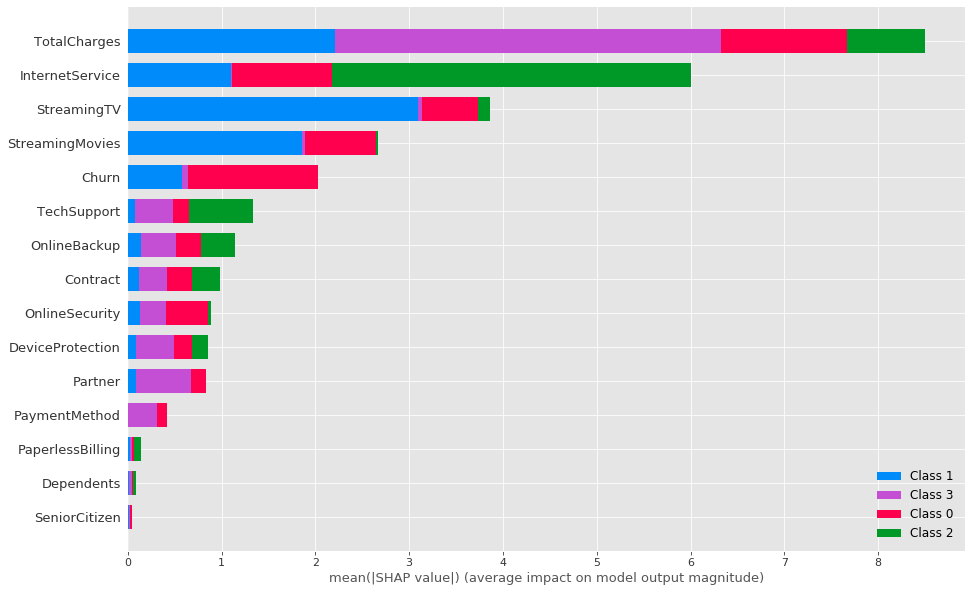

In [65]:
shap.summary_plot(shap_values_kp, cat_data, plot_type="bar", plot_size=(15, 10))

The model produces an F1 score close to 1, which means that clusters were produced which are easily distinguishable, however there is a steep drop off in the number of features used to classify the 